<a href="https://colab.research.google.com/github/algo-ryth-nic/google-colab-notebooks/blob/master/DE_market_basket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apriori Alogrithm
## What is Apriori Algorithm
It is a machine learning algorithm used on "Transactional Datasets" to mine frequent items and relevant association rules. The information obtained is used to gain an insight in the various relationships between different items in the dataset.

## Why use it?
A popular applicaiton of this is used in Market Basket Analysis, recommendation systems.

### Advantages & Disadvantages
| Advantage      | Disadvantage |
| ----------- | ----------- |
| Easy to implement      | Slow       |
| Can be used on large datasets   | too many database scans        |

In [ ]:
! pip install mlxtend

In [ ]:
# fetches the dataset from url
def fetch(url):
  import requests, os, re

  pattern = r'[^\/]+\/?$'
  fileName = re.search(pattern, url)[0]
  # removes any trailing '/'
  fileName = fileName.replace('/','')
  
  fp = os.path.join('/content', fileName)
  with open(fp, 'wb') as f:
         res = requests.get(url).content
         f.write(res)

  return fp

In [ ]:
fetch('https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx')

'/content/online_retail_II.xlsx'

## Loading Transcational Type Dataset
Dataset : Groceries Data Set <br>
Link: [UCI Online Retail II](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II)

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_excel('/content/DataSet_5.1_Online Retail.xlsx')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [ ]:
# As one can see, this a very large dataset (500k+ entries, 8 cols)
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df['Country'].value_counts().head(10)

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64

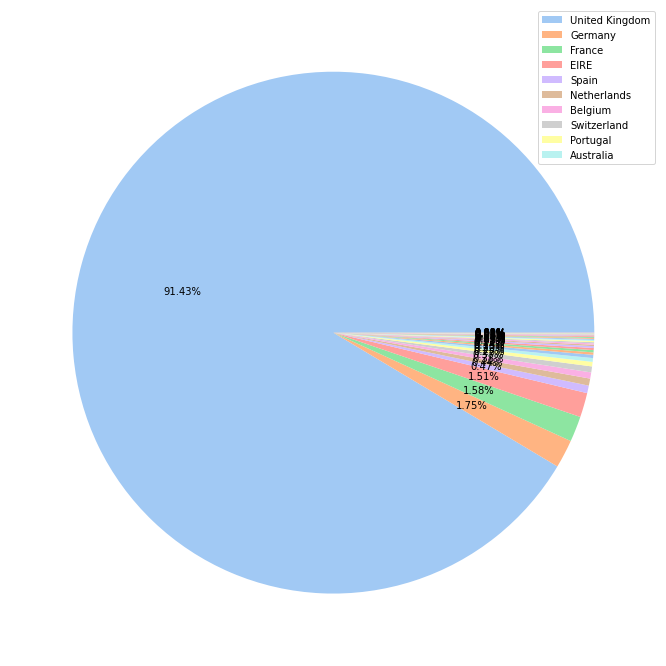

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,12))
colors = sns.color_palette('pastel')
plt.pie(df['Country'].value_counts(), labels = None, autopct='%1.2f%%', colors =colors);
plt.legend(df['Country'].value_counts()[:10].index, loc="upper right");

## Data cleaning

In [ ]:
# removing trailing and beginning spaces (if exists)
df['Description'] = df['Description'].str.strip() 
df['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
                                      ... 
showroom                                 1
damages/showroom etc                     1
CURIOUS IMAGES SCRAP BOOK SET            1
LASER CUT MULTI STRAND NECKLACE          1
BAKING MOULD TOFFEE CUP  CHOCOLATE       1
Name: Description, Length: 4210, dtype: int64

In [ ]:
# unique values of invoice
df['InvoiceNo'].value_counts()

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
564164        1
564163        1
564160        1
C552043       1
C577323       1
Name: InvoiceNo, Length: 25900, dtype: int64

In [ ]:
# dropping those done on credit eg. C577384, since quantity is in -ve?
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
on_credit = df[df['InvoiceNo'].str.contains(r'C', regex=True)]

# roundabout way of just pretty printing dataframe :/ 🤷‍♀️
from IPython.display import display, HTML 
display(HTML(on_credit.head(5).to_html()))


# removing these entries 
df = df[~df['InvoiceNo'].str.contains(r'C', regex=True)]
print(f'\n[df] Entries removed: {on_credit.shape[0]}\n[df] Updated Shape: {df.shape}')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom



[df] Entries removed: 9288
[df] Updated Shape: (532621, 8)


In [ ]:
# since some quantities are in -ve, which can not be possible, removing them
df = df[df['Quantity'] > 0]

In [ ]:
df.shape

(531285, 8)

In [ ]:
# Shall be looking at the data for a single country: Spain
df_spain = df[df.Country == 'Spain']
df_spain.rename(columns={'Description':'Item'}, inplace=True);
df_spain.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,InvoiceNo,StockCode,Item,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6421,536944,22383,LUNCH BAG SUKI DESIGN,70,2010-12-03 12:20:00,1.65,12557.0,Spain
6422,536944,22384,LUNCH BAG PINK POLKADOT,100,2010-12-03 12:20:00,1.45,12557.0,Spain
6423,536944,20727,LUNCH BAG BLACK SKULL.,60,2010-12-03 12:20:00,1.65,12557.0,Spain
6424,536944,20725,LUNCH BAG RED RETROSPOT,70,2010-12-03 12:20:00,1.65,12557.0,Spain
6425,536944,20728,LUNCH BAG CARS BLUE,100,2010-12-03 12:20:00,1.45,12557.0,Spain


In [ ]:
basket = pd.pivot_table(data=df_spain, 
                        index='InvoiceNo',
                        columns='Item',
                        values='Quantity',
                        aggfunc='sum',
                        fill_value=0)

basket.head(5)

Item,10 COLOUR SPACEBOY PEN,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 ROSE MORRIS BOXED CANDLES,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,3 WHITE CHOC MORRIS BOXED CANDLES,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 EGG HOUSE PAINTED WOOD,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,6 RIBBONS ELEGANT CHRISTMAS,6 RIBBONS EMPIRE,6 RIBBONS RUSTIC CHARM,6 RIBBONS SHIMMERING PINKS,60 CAKE CASES VINTAGE CHRISTMAS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,...,WOOD STAMP SET THANK YOU,WOODEN ADVENT CALENDAR RED,WOODEN BOX OF DOMINOES,WOODEN CROQUET GARDEN SET,WOODEN FRAME ANTIQUE WHITE,WOODEN HAPPY BIRTHDAY GARLAND,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN PICTURE FRAME WHITE FINISH,WOODEN ROUNDERS GARDEN SET,WOODEN SCHOOL COLOURING SET,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN TREE CHRISTMAS SCANDINAVIAN,WOODEN UNION JACK BUNTING,WOODLAND HEIGHT CHART STICKERS,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND MINI BACKPACK,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL RED FELT HEART,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP ALPHABET DESIGN,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YELLOW FLOWERS FELT HANDBAG KIT,ZINC FOLKART SLEIGH BELLS,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
538095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
538525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
539351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
540469,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0


In [ ]:
basket['LUNCH BAG RED RETROSPOT'].head(10)

InvoiceNo
536944    70
538095     0
538525     0
539351     0
540469     4
540550     0
540785     0
540801     0
541491     0
541576     0
Name: LUNCH BAG RED RETROSPOT, dtype: int64

In [ ]:
# One Hotting it now, since we dont care about the quantity value.

def convert_into_binary(x):
    if x > 0:
        return 1
    else:
        return 0

basket_sets = basket.applymap(convert_into_binary)

In [ ]:
basket_sets['LUNCH BAG RED RETROSPOT'].head(10)

InvoiceNo
536944    1
538095    0
538525    0
539351    0
540469    1
540550    0
540785    0
540801    0
541491    0
541576    0
Name: LUNCH BAG RED RETROSPOT, dtype: int64

## Implementing Apriori Algorithm


In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# minimum support = 7%. Atleast 7 times that item was present in total transaction.
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.166667,(6 RIBBONS RUSTIC CHARM)
1,0.077778,(ALARM CLOCK BAKELIKE GREEN)
2,0.133333,(ASSORTED COLOUR BIRD ORNAMENT)
3,0.111111,(CLASSIC METAL BIRDCAGE PLANT HOLDER)
4,0.100000,(DOLLY GIRL LUNCH BOX)
5,0.077778,(DOORMAT SPOTTY HOME SWEET HOME)
6,0.155556,(JAM MAKING SET WITH JARS)
7,0.111111,(LUNCH BAG PINK POLKADOT)
8,0.088889,(LUNCH BAG RED RETROSPOT)
9,0.088889,(PACK OF 60 PINK PAISLEY CAKE CASES)


$$lift = \frac{support (X \bigcup Y)}{support(X) * support(Y)}$$

In [ ]:
# association rules which needs frequent itemset.
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_mlxtend.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(6 RIBBONS RUSTIC CHARM),(ASSORTED COLOUR BIRD ORNAMENT),0.166667,0.133333,0.100000,0.600000,4.500000,0.077778,2.166667
1,(ASSORTED COLOUR BIRD ORNAMENT),(6 RIBBONS RUSTIC CHARM),0.133333,0.166667,0.100000,0.750000,4.500000,0.077778,3.333333
2,(6 RIBBONS RUSTIC CHARM),(POSTAGE),0.166667,0.688889,0.144444,0.866667,1.258065,0.029630,2.333333
3,(POSTAGE),(6 RIBBONS RUSTIC CHARM),0.688889,0.166667,0.144444,0.209677,1.258065,0.029630,1.054422
4,(POSTAGE),(ASSORTED COLOUR BIRD ORNAMENT),0.688889,0.133333,0.122222,0.177419,1.330645,0.030370,1.053595
